In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# RTX On
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [ ]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):

    model = tf.keras.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(3072,)))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,)))
    
    # C₁ Convolutional Layer
    model.add(layers.Conv2D(num_ch_c1, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))

    # S₁ Max Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2), padding='valid'))
    
    # C₂ Convolutional Layer
    model.add(layers.Conv2D(num_ch_c2, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))

    # S₂ Max Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2), padding='valid'))

    # Flatten
    model.add(layers.Flatten())
    
    # F₃ Fully-Connected Layer
    model.add(layers.Dense(300, activation=None, use_bias=True, input_shape=(300,)))  # Here no softmax because we have combined it with the loss   
    
    # F₄ Fully-Connected Layer 
    model.add(layers.Dense(10, activation='softmax', use_bias=True, input_shape=(300,)))  # Here no softmax because we have combined it with the loss   
        
    return model

In [ ]:
model.summary()

In [2]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Disabled, as we use grid search space values below
# num_ch_c1 = 50  # Question 2
# num_ch_c2 = 60  # Question 2

epochs = 1000  # Fixed
batch_size = 128  # Fixed
learning_rate = 0.001

optimizer_ = 'SGD'  # Question 3
use_dropout = False  # Question 3(d) (see make_model)

In [7]:
# disabled, as we're using grid search below
# model = make_model(num_ch_c1, num_ch_c2, use_dropout) 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
if optimizer_ == 'SGD':
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
elif optimizer_ == 'SGD-momentum':  # Question 3(a)
    momentum = 0.1
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
elif optimizer_ == 'RMSProp':  # Question 3(b)
    optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
elif optimizer_ == 'Adam':  # Question 3(c)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
else:
    raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

In [ ]:
# Create folder to store models and results
'''
if not os.path.exists('./models'):
    os.mkdir('./models')
if not os.path.exists('./results'):
    os.mkdir('./results')
'''

In [ ]:
'''
Load Training and Test Datasets
'''
x_train, y_train = load_data('/content/gdrive/My Drive/Colab Notebooks/data_batch_1')
x_test, y_test = load_data('/content/gdrive/My Drive/Colab Notebooks/test_batch_trim')

In [ ]:
'''
Create Model Combinations
'''
c1_space = [10, 30, 50, 70, 90]
c2_space = [20, 40, 60, 80, 100]
model_combination_list = []

for c1_channels in c1_space:
    for c2_channels in c2_space:

        num_ch_c1 = c1_channels
        num_ch_c2 = c2_channels

        # Create folder to store one more level down
        if not os.path.exists(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout'):
            os.mkdir(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
        if not os.path.exists(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout'):
            os.mkdir(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')
        # Note: 50_60_SGD already exists, so it will be overwritten later on.

        model = make_model(num_ch_c1, num_ch_c2, use_dropout)
        model_combination_list.append([model, num_ch_c1, num_ch_c2])

In [ ]:
'''
Train Model
'''
aggregate_variables_list = []

for each in model_combination_list:

    model, num_ch_c1, num_ch_c2 = each

    # Train Model
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test))
    
    # Save model
    if use_dropout:
        model.save(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
    else:
        model.save(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')

    # Extract Loss Values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract Accuracy Values
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Store model combination's instanced variables into a list
    instanced_variables = [train_loss, val_loss, train_acc, val_acc, num_ch_c1, num_ch_c2]
    aggregate_variables_list.append(instanced_variables)

Streaming output truncated to the last 5000 lines.
Epoch 503/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1547 - accuracy: 0.3068 - val_loss: 2.1611 - val_accuracy: 0.2970
Epoch 504/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.1544 - accuracy: 0.3060 - val_loss: 2.1611 - val_accuracy: 0.2945
Epoch 505/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1541 - accuracy: 0.3056 - val_loss: 2.1649 - val_accuracy: 0.2955
Epoch 506/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1538 - accuracy: 0.3060 - val_loss: 2.1639 - val_accuracy: 0.2975
Epoch 507/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1541 - accuracy: 0.3071 - val_loss: 2.1625 - val_accuracy: 0.3005
Epoch 508/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1541 - accuracy: 0.3077 - val_loss: 2.1607 - val_accuracy: 0.2965
Epoch 509/1000
79/79 [==============================] - 0s 5ms/step - loss: 2.1536 - 

In [ ]:
# Save instanced variables w/ pickle rick
filename = '/content/gdrive/My Drive/Colab Output/part_a_q2_variables'
outfile = open(filename,'wb')

pickle.dump(aggregate_variables_list, outfile)
outfile.close()

In [3]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open('/content/gdrive/My Drive/Colab Output/part_a_q2_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
retrieved_aggregate_variables_list = retrieved_variables

In [4]:
for each in retrieved_aggregate_variables_list:
    
    train_loss, val_loss, train_acc, val_acc, num_ch_c1, num_ch_c2 = each
    
    # Loss Plots
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title(f'{num_ch_c1}_{num_ch_c2}_{optimizer_} Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.png')
    else:
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf')
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.png')
    plt.close()

    # Accuracy Plots
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Test')
    plt.title(f'{num_ch_c1}_{num_ch_c2}_{optimizer_} Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf')
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.png')
    else:
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf')
        plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.png')
    plt.close()

<function matplotlib.pyplot.close>

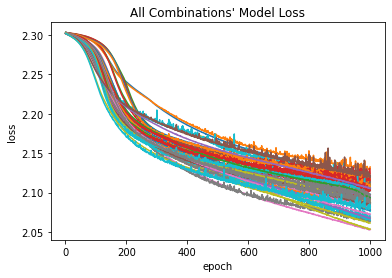

In [ ]:
# Print Aggregate Loss
for each in retrieved_aggregate_variables_list:
    
    train_loss, val_loss, train_acc, val_acc, num_ch_c1, num_ch_c2 = each
    
    # Aggregate Loss Plots
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title(f'All Combinations\' Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend()

if use_dropout:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_dropout_loss.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_dropout_loss.png')
else:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_no_dropout_loss.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_no_dropout_loss.png')

plt.close

<function matplotlib.pyplot.close>

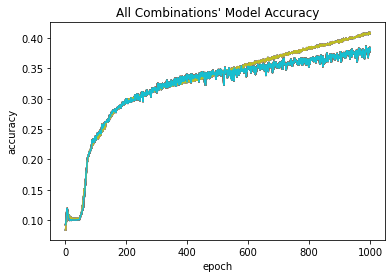

In [ ]:
# Print Accuracy Loss
for each in retrieved_aggregate_variables_list:
    
    # Aggregate Accuracy Plots
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Test')
    plt.title(f'All Combinations\' Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend()

if use_dropout:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_dropout_accuracy.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_dropout_accuracy.png')
else:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_no_dropout_accuracy.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/all_combinations_no_dropout_accuracy.png')

plt.close

In [5]:
c1_space = [10, 30, 50, 70, 90]
c2_space = [20, 40, 60, 80, 100]

In [6]:
c1_list = []
c2_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Result Analysis
for each in retrieved_aggregate_variables_list:
    
    train_loss, val_loss, train_acc, val_acc, num_ch_c1, num_ch_c2 = each

    for tl_each in train_loss:
        c1_list.append(num_ch_c1)
        c2_list.append(num_ch_c2)
        train_loss_list.append(tl_each)
    
    for vl_each in val_loss:
        val_loss_list.append(vl_each)
    
    for ta_each in train_acc:
        train_acc_list.append(ta_each)
    
    for va_each in val_acc:
        val_acc_list.append(va_each)

analysis_df = pd.DataFrame()
analysis_df['C1'] = c1_list
analysis_df['C2'] = c2_list
analysis_df['Train Loss'] = train_loss_list
analysis_df['Val Loss'] = val_loss_list
analysis_df['Train Acc'] = train_acc_list
analysis_df['Val Acc'] = val_acc_list
analysis_df

,C1,C2,Train Loss,Val Loss,Train Acc,Val Acc
0,10,20,2.302599,2.302507,0.1198,0.1210
1,10,20,2.302536,2.302450,0.1228,0.1250
2,10,20,2.302477,2.302396,0.1271,0.1310
3,10,20,2.302420,2.302342,0.1301,0.1370
4,10,20,2.302364,2.302287,0.1353,0.1340
...,...,...,...,...,...,...
24995,90,100,2.061338,2.079497,0.4096,0.3820
24996,90,100,2.061199,2.079825,0.4074,0.3830
24997,90,100,2.061186,2.085372,0.4063,0.3760
24998,90,100,2.061250,2.079427,0.4093,0.3845


In [7]:
# Function to cherry pick min loss values
choice_list = []
for c1_each in c1_space:
    for c2_each in c2_space:
        holder_df = analysis_df.loc[(analysis_df['C1'] == c1_each) & (analysis_df['C2'] == c2_each)]
        min_train_loss = holder_df["Train Loss"].min()
        min_val_loss = holder_df["Val Loss"].min()
        max_train_loss = holder_df["Train Acc"].min()
        max_val_loss = holder_df["Val Acc"].min()
        choice_list.append([c1_each, c2_each, min_train_loss, min_val_loss, max_train_loss, max_val_loss])

In [8]:
c1_list = []
c2_list = []
tl_list = []
vl_list = []
ta_list = []
va_list = []

for each in choice_list:
    c1_list.append(each[0])
    c2_list.append(each[1])
    tl_list.append(each[2])
    vl_list.append(each[3])
    ta_list.append(each[4])
    va_list.append(each[5])

test_choice_df = pd.DataFrame()
test_choice_df['C1'] = c1_list
test_choice_df['C2'] = c2_list
test_choice_df['Min Train Loss'] = tl_list
test_choice_df['Max Train Acc'] = ta_list

val_choice_df = pd.DataFrame()
val_choice_df['C1'] = c1_list
val_choice_df['C2'] = c2_list
val_choice_df['Min Val Loss'] = vl_list
val_choice_df['Max Val Acc'] = va_list

In [14]:
# Display Best 5 Channel Combination Pairs in terms of Train Loss and Acc
test_choice_df.sort_values(by=['Min Train Loss', 'Max Train Acc'], ascending=[True, False]).head()

,C1,C2,Min Train Loss,Max Train Acc
8,30,80,2.052537,0.0983
14,50,100,2.053296,0.1003
24,90,100,2.061186,0.0837
17,70,60,2.067014,0.1007
9,30,100,2.068214,0.1023


In [13]:
# Display Best 5 Channel Combination Pairs in terms of Val Loss and Acc
val_choice_df.sort_values(by=['Min Val Loss', 'Max Val Acc'], ascending=[True, False]).head()

,C1,C2,Min Val Loss,Max Val Acc
8,30,80,2.062711,0.1000
14,50,100,2.064874,0.1000
9,30,100,2.076043,0.1065
24,90,100,2.078484,0.0925
15,70,20,2.079346,0.0960


In [ ]:
'''
We thus choose:
C1 = 30
C2 = 80 
'''